# Анализ результатов А/В-теста

## Цель, техническое задание, описание данных

### Цель

Главная ззадача — провести оценку результатов A/B-теста:

- Оценить корректность проведения теста
- Проанализировать его результаты.

Чтобы оценить корректность проведения теста, необходимо:
- Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.


### Техническое задание

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%: 
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase.


### Описание данных

**`ab_project_marketing_events.csv`** — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

**`final_ab_new_users.csv`** — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

**`final_ab_events.csv`** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

**`final_ab_participants.csv`** — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Декомпозиция задач

1) Импорт необходимых библиотек и загрузка данных

2) Предобработка данных:
    - проверка названий столбцов
    - проверка типов данных
    - проверка пропусков
    - проверка дубликатов
    
3) Анализ корректности сбора данных
    - исследование дат регистраций пользователей
    
    - исследование количества участников и доли пользователей из Европы
    
    - исследование на пересечение в группах
    
    - исследование равномерности распределения пользователей по группам
    
    - исследование событий
    
    - исследование пользователей, которые не совершали действий
    
    - исследование лайфтайма каждого пользователя
    
    - исследование маркетинговых кампаний
    
4) Исследовательский анализ

    - анализ количества событий на пользователя
    
    - анализ количества событий в группах по дням
    
5) Оценка результатов А/В-теста

## Импорт необходимых библиотек и загрузка данных

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go

In [2]:
events = pd.read_csv('final_ab_events.csv')
project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
participants = pd.read_csv('final_ab_participants.csv')

## Предобработка данных

In [3]:
# Создам функцию для просмотра информации по каждой таблице
def df_info(table):
    print()
    print('Первые 3 строки таблицы:')
    display(table.head(3))
    print('-'*100)
    print()
    print('Общая информация по таблице:')
    print()
    display(table.info())
    print('-'*100)
    print()
    print('Доля пропусков в таблице:')
    display(table.isna().mean())
    print('-'*100)
    print()
    print('Доля явных дубликатов в таблице:', table.duplicated().mean())
    print('-'*100)

### Таблица project_marketing_events

In [4]:
# Зафиксирую количество строк в таблице project_marketing_events до обработки данных
cnt_str_mark_ev = project_marketing_events.shape[0]
print()
print('Количество строк в таблице project_marketing_events до обработки данных:', cnt_str_mark_ev)


Количество строк в таблице project_marketing_events до обработки данных: 14


In [5]:
# Выведу всю необходимую информацию по таблице project_marketing_events
df_info(project_marketing_events)


Первые 3 строки таблицы:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


----------------------------------------------------------------------------------------------------

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

----------------------------------------------------------------------------------------------------

Доля пропусков в таблице:


name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

----------------------------------------------------------------------------------------------------

Доля явных дубликатов в таблице: 0.0
----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>
    - Названия столбцов корректны<br>
<font color='DarkMagenta'>   
    - Пропусков нет<br>
<font color='DarkMagenta'>    
    - Дубликатов нет<br>
<font color='DarkMagenta'>    
    - Изменить тип данных колонок start_dt и finish_dt на datetime<br></font>

In [6]:
# Поменяю тип данных столбцов start_dt и finish_dt
project_marketing_events['start_dt'] = pd.to_datetime(project_marketing_events['start_dt'])
project_marketing_events['finish_dt'] = pd.to_datetime(project_marketing_events['finish_dt'])

# Проверю, что типы колонок изменились
print(project_marketing_events[['start_dt', 'finish_dt']].dtypes)

start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object


In [7]:
# Проверю на неявные дубликаты: посмотрю на уникальные значения колонок name и regions
print()
print('Значения колонки name')
display(project_marketing_events['name'].sort_values().unique())
print('-'*100)
print()
print('Значения колонки regions')
display(project_marketing_events['regions'].sort_values().unique())
print('-'*100)


Значения колонки name


array(['4th of July Promo', 'Black Friday Ads Campaign',
       'CIS New Year Gift Lottery', 'Chinese Moon Festival',
       'Chinese New Year Promo', 'Christmas&New Year Promo',
       'Dragon Boat Festival Giveaway', 'Easter Promo',
       "International Women's Day Promo",
       'Labor day (May 1st) Ads Campaign', "Single's Day Gift Promo",
       "St. Patric's Day Promo", "St. Valentine's Day Giveaway",
       'Victory Day CIS (May 9th) Event'], dtype=object)

----------------------------------------------------------------------------------------------------

Значения колонки regions


array(['APAC', 'CIS', 'EU, CIS, APAC', 'EU, CIS, APAC, N.America',
       'EU, N.America', 'N.America'], dtype=object)

----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>Неявных дубликатов нет

In [8]:
# Зафиксирую количество строк после обработки данных
cnt_str_mark_ev_proces = project_marketing_events.shape[0]

print()
print('Количество строк в таблице project_marketing_events после обработки данных:', cnt_str_mark_ev_proces)
print(f'Удалили {cnt_str_mark_ev - cnt_str_mark_ev_proces} строк')


Количество строк в таблице project_marketing_events после обработки данных: 14
Удалили 0 строк


### Таблица events


In [9]:
# Зафиксирую количество строк в таблице events до обработки данных
cnt_str_ev = events.shape[0]
print()
print('Количество строк в таблице events до обработки данных:', cnt_str_ev)


Количество строк в таблице events до обработки данных: 440317


In [10]:
# Выведу всю необходимую информацию по таблице events
df_info(events)


Первые 3 строки таблицы:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


----------------------------------------------------------------------------------------------------

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

----------------------------------------------------------------------------------------------------

Доля пропусков в таблице:


user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.857512
dtype: float64

----------------------------------------------------------------------------------------------------

Доля явных дубликатов в таблице: 0.0
----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>
    - Названия столбцов корректны<br>
    <font color='DarkMagenta'>
    - Дубликатов нет<br>
      <font color='DarkMagenta'>
    - В столбце details почти 86% пропусков. Ничего с этими пропусками делать не буду, т.к. по условию проекта колонка details содержит дополнительные данные. Значит на месте пропусков нет дополнительных данных.<br>
          <font color='DarkMagenta'>  
    - Столбец event_dt привести к формату datetime<br></font>

In [11]:
# Поменяю тип данных столбцов event_dt
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Проверю, что тип колонки изменился
print(events['event_dt'].dtypes)

datetime64[ns]


In [12]:
# Проверю на неявные дубликаты: посмотрю на уникальные значения колонки event_name
print()
print('Значения колонки event_name')
display(events['event_name'].sort_values().unique())
print('-'*100)


Значения колонки event_name


array(['login', 'product_cart', 'product_page', 'purchase'], dtype=object)

----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>Неявных дубликатов нет

In [13]:
# Зафиксирую количество строк после обработки данных
cnt_str_ev_proces = events.shape[0]

print()
print('Количество строк в таблице events после обработки данных:', cnt_str_ev_proces)
print(f'Удалили {cnt_str_ev - cnt_str_ev_proces} строк')


Количество строк в таблице events после обработки данных: 440317
Удалили 0 строк


### Таблица new_users

In [14]:
# Зафиксирую количество строк в таблице new_users до обработки данных
cnt_str_new_us = new_users.shape[0]
print()
print('Количество строк в таблице new_users до обработки данных:', cnt_str_new_us)


Количество строк в таблице new_users до обработки данных: 61733


In [15]:
# Выведу всю необходимую информацию по таблице new_users
df_info(new_users)


Первые 3 строки таблицы:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


----------------------------------------------------------------------------------------------------

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

----------------------------------------------------------------------------------------------------

Доля пропусков в таблице:


user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

----------------------------------------------------------------------------------------------------

Доля явных дубликатов в таблице: 0.0
----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>
    - Названия столбцов корректны<br>
<font color='DarkMagenta'>
    - Пропусков нет<br>
<font color='DarkMagenta'>
    - Дубликатов нет<br>
<font color='DarkMagenta'>
    - Столбец first_date привести к типу данных datetime<br></font>

In [16]:
# Поменяю тип данных столбца first_date
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

# Проверю, что тип колонки изменился
print(new_users['first_date'].dtypes)

datetime64[ns]


In [17]:
# Проверю на неявные дубликаты: посмотрю на уникальные значения колонок region и device
print()
print('Значения колонки region')
display(new_users['region'].sort_values().unique())
print('-'*100)
print()
print('Значения колонки device')
display(new_users['device'].sort_values().unique())
print('-'*100)


Значения колонки region


array(['APAC', 'CIS', 'EU', 'N.America'], dtype=object)

----------------------------------------------------------------------------------------------------

Значения колонки device


array(['Android', 'Mac', 'PC', 'iPhone'], dtype=object)

----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>Неявных дубликатов нет. Названия регионов идентичны названию регионов в таблице events

In [18]:
# Зафиксирую количество строк после обработки данных
cnt_str_new_us_proces = new_users.shape[0]

print()
print('Количество строк в таблице new_users после обработки данных:', cnt_str_new_us_proces)
print(f'Удалили {cnt_str_new_us - cnt_str_new_us_proces} строк')


Количество строк в таблице new_users после обработки данных: 61733
Удалили 0 строк


### Таблица participants

In [19]:
# Зафиксирую количество строк в таблице participants до обработки данных
cnt_str_part = participants.shape[0]
print()
print('Количество строк в таблице new_users до обработки данных:', cnt_str_part)


Количество строк в таблице new_users до обработки данных: 18268


In [20]:
# Выведу всю необходимую информацию по таблице participants
df_info(participants)


Первые 3 строки таблицы:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


----------------------------------------------------------------------------------------------------

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

----------------------------------------------------------------------------------------------------

Доля пропусков в таблице:


user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

----------------------------------------------------------------------------------------------------

Доля явных дубликатов в таблице: 0.0
----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>
    - Названия столбцов корректны<br>
<font color='DarkMagenta'>    
    - Пропусков нет<br>
<font color='DarkMagenta'>    
    - Дубликатов нет<br>
<font color='DarkMagenta'>    
    - Все столбцы имеют корректный тип данных<br></font>

In [21]:
# Проверю на неявные дубликаты: посмотрю на уникальные значения колонок group и ab_test
print()
print('Значения колонки group')
display(participants['group'].sort_values().unique())
print('-'*100)
print()
print('Значения колонки ab_test')
display(participants['ab_test'].sort_values().unique())
print('-'*100)


Значения колонки group


array(['A', 'B'], dtype=object)

----------------------------------------------------------------------------------------------------

Значения колонки ab_test


array(['interface_eu_test', 'recommender_system_test'], dtype=object)

----------------------------------------------------------------------------------------------------


<font color='DarkMagenta'>Неявных дубликатов не выявлено. В таблице participants содержится информация о 2-х тестах

In [22]:
# Зафиксирую количество строк после обработки данных
cnt_str_part_proces = participants.shape[0]

print()
print('Количество строк в таблице new_users после обработки данных:', cnt_str_part_proces)
print(f'Удалили {cnt_str_part - cnt_str_part_proces} строк')


Количество строк в таблице new_users после обработки данных: 18268
Удалили 0 строк


### Выводы по преобработке данных

Вывод по этапу предобработки данных:
    
   - таблица **project_marketing_events** - привели тип данных столбцов start_df и finish_df к формату date_time
   - таблица **events** - привели тип данных столбца event_dt к формату datetime, пропуски в колонке details оставили без изменений 
   - таблица **new_users** - привели тип данных столбца first_date к формату datetime
   - таблица **participants** не нуждалась ни в каких изменениях, в таблице содержится информация о 2-х тестах
   - дубликаты отсутствовали во всех таблицах

## Анализ корректности проведения теста

### Объединение датасетов

In [23]:
# Для дальнйшей работы объединю датасеты new_users, participants и events
df = new_users.merge(participants, on='user_id', how='outer')
df = df.merge(events, on='user_id', how='outer')

In [24]:
# Для удобства в работе при расчетах пересечений пользователей заменю названия групп А и В теста interface_eu_test на А1 и В1 соответственно
df['group'] = np.where((df['group'] == 'A') & (df['ab_test'] == 'interface_eu_test'), 'A1', df['group'])
df['group'] = np.where((df['group'] == 'B') & (df['ab_test'] == 'interface_eu_test'), 'B1', df['group'])

### Исследование дат регистрации пользователей

In [25]:
# Проверю за какие даты предоставлена информация о регистрации пользователей
print()
print('Минимальная дата регистрации пользователей:', df['first_date'].min())
print('Максимальная дата регистрации пользователей:', df['first_date'].max())


Минимальная дата регистрации пользователей: 2020-12-07 00:00:00
Максимальная дата регистрации пользователей: 2020-12-23 00:00:00


<font color='DarkMagenta'>Набор новых пользователей в наш тест был завершен 23 декабря. В задании сказано, что набор должен был быть остановлен 21 декабря.

In [26]:
# Посмотрю на последнюю дату регистации пользователей, которые приняли участие в тесте
print('Последняя дата регистации пользователей, которые приняли участие в тестеt:',
      df.query('ab_test == "recommender_system_test"')['first_date'].max())

Последняя дата регистации пользователей, которые приняли участие в тестеt: 2020-12-21 00:00:00


<font color='DarkMagenta'> В тесте принимали участие пользователи, которые зарегистрировались с 2020-12-07  до 2020-12-21 включительно. Это соответствует техническому заданию.

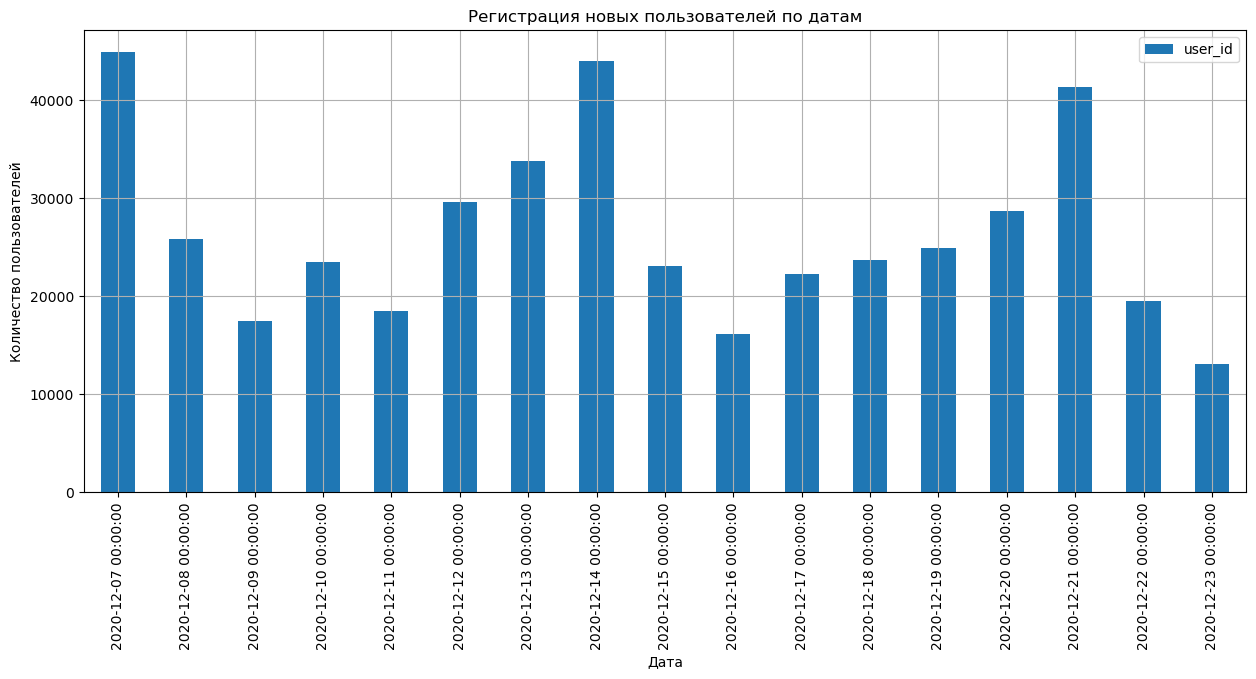

In [27]:
# Посмотрю как добавлялись новые пользователи по датам
(
    df
    .groupby('first_date').agg({'user_id':'count'})
    .plot(kind='bar',
          grid=True,
          figsize=(15,6)
         )
)
plt.title('Регистрация новых пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

<font color='DarkMagenta'> Больше всех пользователей пришло 2020-12-14 и 2020-12-21

### Исследование количества участников и доли пользователей из Европы

In [28]:
# Посчитаю общее количество новых пользователей
print()
print('Общее количество новых пользователей приложения за период 2020-12-07 по 2020-12-21:', df['user_id'].nunique())
print('-'*100)
# Посчитаю количество новых пользователей из Европы
us_eu_cnt = df[df['region'] == 'EU']['user_id'].nunique()
print()
print('Общее количество новых пользователей из Европы:', us_eu_cnt)


Общее количество новых пользователей приложения за период 2020-12-07 по 2020-12-21: 61733
----------------------------------------------------------------------------------------------------

Общее количество новых пользователей из Европы: 46270


In [29]:
# Посмотрю на общее количестов, количество и долю пользователей из Европы, принимавших участие в тесте recommender_system_test

# Посмотрю на общее количество пользователей.По условию количество участников ожидается 6000
print()
print('Количество участников в тесте recommender_system_test:', 
      df.query('ab_test == "recommender_system_test"')['user_id'].nunique())
print('-'*100)
# В тест должно быть отобрано только 15% новых пользователей из Европы от общего количества пользоателей из Европы
# Посчитаю количество всех новых пользователей из Европы, принимавших участие в тесте
us_eu_ab_cnt = df.query('ab_test == "recommender_system_test" and region == "EU"')['user_id'].nunique()
print()
print('Количество пользователей из Европы в тесте recommender_system_test', us_eu_ab_cnt)
print('-'*100)
print()
print('Доля европейский пользователей в тесте recommender_system_test, от всего количества европейских пользователей:', 
      "{:.2%}".format(us_eu_ab_cnt/us_eu_cnt))


Количество участников в тесте recommender_system_test: 6701
----------------------------------------------------------------------------------------------------

Количество пользователей из Европы в тесте recommender_system_test 6351
----------------------------------------------------------------------------------------------------

Доля европейский пользователей в тесте recommender_system_test, от всего количества европейских пользователей: 13.73%


<font color='DarkMagenta'>В тест попали не только пользователи из Европы, но количество европейских пользователей в тесте соответствует ожидаемому количеству. И их доля от общего количества пользователей составляет 15%, как и должно быть по условию теста.

In [30]:
# Дальше для исследования нам нужны будут только пользователи из Европы, поэтому оставим в датафрейме только этот регион.
df = df.query('region == "EU"')

### Исследование на пересечение в группах

In [31]:
# Создам переменную id пользователей в группе А
id_a = df[df['group'] == 'A']['user_id']
# Создам переменную id пользователей в группе В
id_b = df[df['group'] == 'B']['user_id']
# Создам переменную id пользователей в группе A1
id_a1 = df[df['group'] == 'A1']['user_id']
# Создам переменную id пользователей в группе B1
id_b1 = df[df['group'] == 'B1']['user_id']

In [32]:
# Сделаю срез таблицы df , в котором id пользователей одновременно есть и в группе А и В. 
#Вынесу его в отдельную переменную
user_a_b = df.query('user_id in @id_a and user_id in @id_b')

# Сделаю срез таблицы df , в котором id пользователей одновременно есть и в группах A и В1 
#Вынесу его в отдельную переменную
user_a_b1 = df.query('user_id in @id_a and user_id in @id_b1')
                     
# Сделаю срез таблицы df , в котором id пользователей одновременно есть и в группах В и В1 
#Вынесу его в отдельную переменную
user_b_b1 = df.query('user_id in @id_b and user_id in @id_b1')

print('Количество пользователей одновременно в группах A и B:', user_a_b['user_id'].nunique())
print('Количество пользователей одновременно в группах A и B1:', user_a_b1['user_id'].nunique())
print('Количество пользователей одновременно в группах B и B1:', user_b_b1['user_id'].nunique())

Количество пользователей одновременно в группах A и B: 0
Количество пользователей одновременно в группах A и B1: 439
Количество пользователей одновременно в группах B и B1: 344


<font color='DarkMagenta'>Между группами исследуемого теста перессечений нет, но есть пересечения обеих групп с группой В теста interface_eu_test. Это может сильно отразиться на результатах теста<br>
<font color='DarkMagenta'>    
    Группа А нашего теста - контрольная. Поэтому удалим из теста пользователей, которые одновременно участвуют в гуппе А нашего теста и в группе В конкурирующего.<br>    
<font color='DarkMagenta'>
    Что делать с пользователями, которые пересекаются в группе В нашего теста и группе В конкурирующего, решу дальше. 

In [33]:
# Удаляю из таблицы пользователей групп А и В1
df = df.query('user_id not in @user_a_b1.user_id')
# Для дальнейшего анализа потребуются только данные по А/В-тесту
df = df.query('ab_test == "recommender_system_test"')

### Исследование равномерности распределения пользователей по группам

In [34]:
user_by_gr = (df
              .groupby('group')['user_id'].nunique()
              .reset_index()
              .rename(columns={'user_id':'users_cnt'})
             )
                 

user_by_gr['ratio_gr_%'] = (user_by_gr['users_cnt']/user_by_gr['users_cnt'].sum()*100).round(2)
user_by_gr


,group,users_cnt,ratio_gr_%
0,A,3195,54.04
1,B,2717,45.96


<font color='DarkMagenta'> В группе А на 8% больше участников. Если удалить из группы В участников, которые пересекаются с группой В конкурирующего теста, то разница станет еще больше и это сильно снизит мощность теста.<br>Поэтому оставлю группу В без изменений.<br></font>

In [35]:
# Посчитаю какое количество участников теста осталось
print('Количество участников в тесте recommender_system_test:', df['user_id'].nunique())

print('Доля европейский пользователей в тесте recommender_system_test, от всего количества европейских пользователей:', 
      "{:.2%}".format(df['user_id'].nunique()/us_eu_cnt))

Количество участников в тесте recommender_system_test: 5912
Доля европейский пользователей в тесте recommender_system_test, от всего количества европейских пользователей: 12.78%


<font color='DarkMagenta'> Снизилось и количество учатников в тесте, и доля пользователей из Европы уже не 15%, но удаление пересекающихся между тестами пользователей было необходимо.

### Исследование  событий

In [36]:
# Переименую столбец event_dt в event_ts (так я буду понимать, что в столбце хранится информация о дата и времени события)
df = df.rename(columns={'event_dt':'event_ts'})

In [37]:
df['event_dt'] = pd.to_datetime(df['event_ts'].dt.strftime('%Y-%m-%d'))

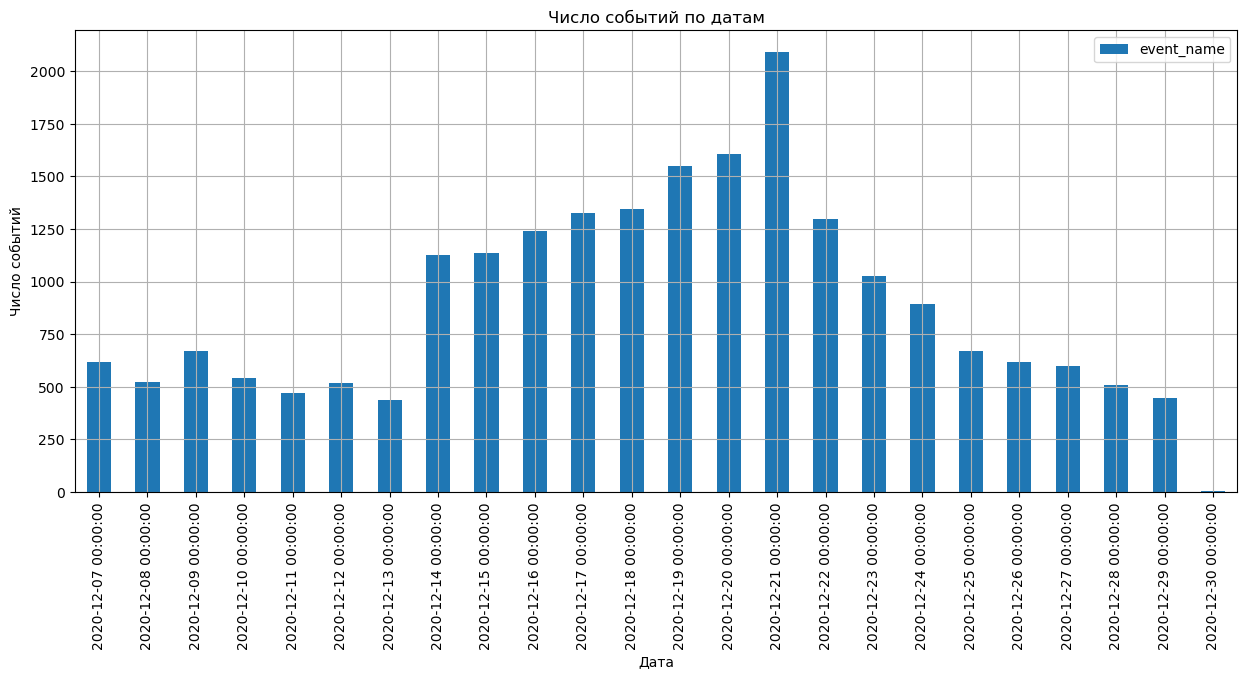

In [38]:
# Посмотрю на распределение количества событий по датам, чтобы убедиться, что данные полные за весь период.
(
    df
    .groupby('event_dt').agg({'event_name':'count'})
    .plot(kind='bar',
          grid=True,
          figsize=(15,6)
         )
)
plt.title('Число событий по датам')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.show()

<font color='DarkMagenta'> Датафрейм содержит события только до 2020-12-30. Но за 2020-12-30 данных мало.   Максимальное количестов событий приходилось на середину периода проведения теста. Как раз в эти даты пришло больше всех пользователей. 

In [39]:
# Посмотрю Помотрю на дату и время последнего события
print('Последнее событие в датасете произошло:', df['event_ts'].max())

Последнее событие в датасете произошло: 2020-12-30 12:42:57


<font color='DarkMagenta'> Данные в таблице только до полудня 2020-12-30. Возможно что-то случилось в новогодние праздники, поэтому данные выгрузились не за весь период. Но с этим мы ничего сделать не можем, будем работать с теми данными, что есть.

### Исследование пользователей, которые не совершали действий

In [40]:
# Проверю все ли пользователи совершали события
event_0 = df[df['event_name'].isna()]
print()
print('Общее количество пользователей в тесте, которые не совершали действий:', event_0['user_id'].nunique())
print('-'*100)
print()
print('Доля пользователей в тесте, которые не совершали действий:', "{:.2%}".format(event_0['user_id'].nunique()/df['user_id'].nunique()))


Общее количество пользователей в тесте, которые не совершали действий: 2756
----------------------------------------------------------------------------------------------------

Доля пользователей в тесте, которые не совершали действий: 46.62%


<font color='DarkMagenta'> Таких пользователей почти половина. Это очень большое количество. Посмотрю как они распределились по группам.

In [41]:
# Срез пользователей группы А
user_a = df.query('group == "A"')
# Пользователи группы А, которые не совершали действий
user_event_0_a = user_a[user_a['event_name'].isna()]
# Срез пользователей группы В
user_b = df.query('group == "B"')
# Пользователи группы В, которые не совершали действий
user_event_0_b = user_b[user_b['event_name'].isna()]
print()
print('Количество пользователей группы А, которые не совершали действий:', user_event_0_a['user_id'].nunique())
print('Количество пользователей группы В, которые не совершали действий:', user_event_0_b['user_id'].nunique())
print('-'*100)
print()
print('Доля пользователей группы А, оторые не совершали действий:',
      "{:.2%}".format(user_event_0_a['user_id'].nunique()/user_a['user_id'].nunique()))
print('Доля пользователей группы В, оторые не совершали действий:',
      "{:.2%}".format(user_event_0_b['user_id'].nunique()/user_b['user_id'].nunique()))


Количество пользователей группы А, которые не совершали действий: 916
Количество пользователей группы В, которые не совершали действий: 1840
----------------------------------------------------------------------------------------------------

Доля пользователей группы А, оторые не совершали действий: 28.67%
Доля пользователей группы В, оторые не совершали действий: 67.72%


<font color='DarkMagenta'> В группе B изначально было меньше пользователей. Теперь еще получили информацию, что 2/3 пользователей, которые не совершили ни одного действия находятся в группе В.

In [42]:
# Окончательно определимся с аудиторией теста. Удалим из таблицы всех пользователей, которые не совершали действий
df = df.query('user_id not in @event_0.user_id')

In [43]:
user_by_gr1 = (df
              .groupby('group')['user_id'].nunique()
              .reset_index()
              .rename(columns={'user_id':'users_cnt'})
             )
                 

user_by_gr1['ratio_gr_%'] = (user_by_gr1['users_cnt']/user_by_gr1['users_cnt'].sum()*100).round(2)
user_by_gr1

,group,users_cnt,ratio_gr_%
0,A,2279,72.21
1,B,877,27.79


<font color='DarkMagenta'> Из всего количества пользователей больше 70% - это пользователи из контрольной группы и только меньше 30% - тестовая. 

### Исследование маркетинговых кампаний

In [44]:
# Посмотрим какие активности выпадают на период проведения теста.
# Выведу список маркетингвых кампаний, дата завершения которых после 2020-12-07
project_marketing_events = project_marketing_events.query('finish_dt > "2020-12-07"')
project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


<font color='DarkMagenta'>На территории Европы во время проведения теста будет проходить только 1 кампания. Но она в равной степени будет влиять на обе группы, поэтому не буду удалять из основного датафрейма даты, в которые совершались события во время проведения маркетинговых активностей. И слишком большой период удалится, что сделает результаты А/В-теста необъективными.

### Исследование лайфтайма

In [45]:
# По условиям задания ожидаемый эффект - улучшение каждой метрики на 10% - должен наступить за 14 дней
# Посчитаю лайфтайм для каждого события пользователя
df['lifetime'] = (df['event_dt'] - df['first_date']).dt.days

In [46]:
# Посмотрю все уникальные значения колонки lifetime
df['lifetime'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [47]:
# В соответствии с заданием оставим только те события, которые произошли только в течении 14 дней после регистрации
df = df[df['lifetime']<=14]

### Выводы по анализу корректности проведения А/В-теста

- Набор новых пользователей в наш тест был завершен 23 декабря. В задании сказано, что набор должен был быть остановлен 21 декабря. Но в тесте приняли участие пользователи, которые зарегистрировались с 2020-12-07  до 2020-12-21 включительно. Это соответствует техническому заданию.

- Больше всех пользователей пришло 2020-12-14 и 2020-12-21

- В тест попали не только пользователи из Европы, но количество европейских пользователей в тесте соответствует ожидаемому количеству. И их доля от общего количества пользователей составляет 15%, как и должно быть по условию теста. 

- Т.к. тест был направлен на пользователей из Европы, то мы удалили пользователей всех других регионов из теста.
   
- Между группами исследуемого теста перессечений нет, но есть пересечения обеих групп с группой В теста interface_eu_test. Это может сильно отразиться на результатах теста
    
- Группа А нашего теста - контрольная. Поэтому удалили из теста пользователей, которые одновременно участвуют в гуппе А нашего теста и и группе В конкурирующего.

- Снизилось и количество учатников в тесте, и доля пользователей из Европы уже не 15%, но удаление пересекающихся между тестами пользователей было необходимо.

- В группе А на 8% больше участников. Если удалить из группы В участников, которые пересекаются с группой В конкурирующего теста, то разница станет еще больше и это сильно снизит мощность теста. Поэтому оставили в группе В нашего теста пользователей, которые попали в группу В конкурирующего теста.

- 2/3 пользователей, которые не совершили ни одного действия находятся в группе В.

- Данные по совершенным событиям есть только за период с 2020-12-07 до полудня 2020-12-30. Возможно что-то случилось в новогодние праздники, поэтому данные выгрузились не за весь период. Но с этим мы ничего сделать не можем, будем работать с теми данными, что есть.

- На территории Европы во время проведения теста будет проходить только 1 маркетинговая кампания. Но она в равной степени будет влиять на обе группы, поэтому не буду удалять из основного датафрейма даты, в которые совершались события во время проведения маркетинговых активностей.

- По ТЗ мы должны проверить конверсию только за 14 дней с момента регистрации пользователя. Удалили в таблице все события, которые произошли после 14 дней с момента регистрации пользователя в приложении.

## Исследовательский анализ

### Количество событий на пользователя

In [48]:
# Посчитаю среднее количество событий на пользователя в каждой группе
events_avg = (df.groupby('group')
              .agg({'event_name':'count',
                   'user_id':'nunique'})
              .rename(columns={'event_name':'events_cnt', 'user_id':'users_cnt'})
             )
events_avg['events_avg'] = (events_avg['events_cnt']/events_avg['users_cnt']).round(2)
events_avg

,events_cnt,users_cnt,events_avg
group,,,
A,15851,2279,6.96
B,4851,877,5.53


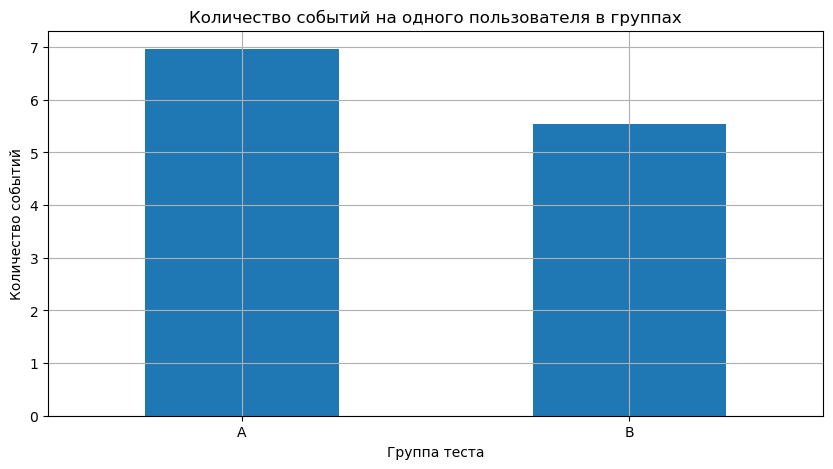

In [49]:
# Посмотрю как добавлялись новые пользователи по датам
(
    events_avg['events_avg']
    .plot(kind='bar',
          grid=True,
          figsize=(10,5)
         )
)
plt.xticks(rotation=0)
plt.title('Количество событий на одного пользователя в группах')
plt.xlabel('Группа теста')
plt.ylabel('Количество событий')
plt.show()

<font color='DarkMagenta'>Пользователь группы А совершает больше событий, чем пользователь группы В.

Проведу статистический тест: сравню среднее количество событий на каждого пользователя между группами

Сформулирую нулевую и альтернативную гипотезы:

    - H0 - Среднее количество событий на одного пользователя в группах А и В одинаково
    - H1 - Среднее количество событий на одного пользователя в группах А и В не одинаково

In [50]:
# Создам таблицу с количеством действий каждого пользователя
cnt_events_per_user = (df
                       .groupby(['user_id', 'group'])['event_name']
                       .count()
                       .reset_index()
                       .rename(columns={'event_name':'events_cnt'})
                      )

# Tаблица с количеством действий каждого пользователя в группе А
cnt_events_per_user_a = cnt_events_per_user[cnt_events_per_user['group']=='A']
# Tаблица с количеством действий каждого пользователя в группе B
cnt_events_per_user_b = cnt_events_per_user[cnt_events_per_user['group']=='B']

In [51]:
print('Среднее количество действий каждого пользователя в группе А', cnt_events_per_user_a['events_cnt'].mean().round(2))
print('Среднее количество действий каждого пользователя в группе B:', cnt_events_per_user_b['events_cnt'].mean().round(2))

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    cnt_events_per_user_a['events_cnt'],
    cnt_events_per_user_b['events_cnt']
)
# alpha = задайте значение уровня значимости
alpha = .05
# вывод значения p-value на экран 
print('p-значение:',results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Среднее количество действий каждого пользователя в группе А 6.96
Среднее количество действий каждого пользователя в группе B: 5.53
p-значение: 9.28786353256608e-22
Отвергаем нулевую гипотезу, между долями есть значимая разница


### Число событий в группах по дням

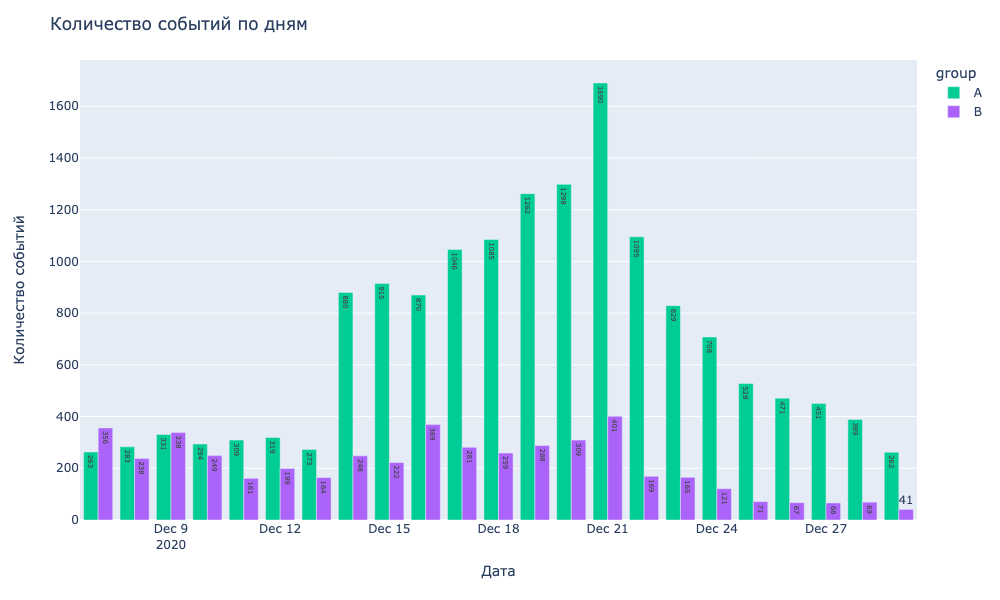

In [52]:
# Исследую число событий в группах по дням
events_by_day = (df.groupby(['event_dt', 'group'])['event_name']
                 .count()
                 .reset_index()
                 .rename(columns={'event_name':'events_cnt'})
                )
                 
# Построю график
fig = px.bar(events_by_day, # загружаем данные и заново их сортируем
             x='event_dt', # указываем столбец с данными для оси X
             y='events_cnt', # указываем столбец с данными для оси Y
             text='events_cnt', # добавляем аргумент, который отобразит текст с информацией
             barmode='group',
             color='group',
             color_discrete_map = {'не сетевое':'darkcyan',
                                    'сетевое': 'darkcyan'},
            width=1000,
            height=600)
fig.update_layout(title='Количество событий по дням',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий'
                 )
fig.show(renderer="png", width=1000, height=600)

<font color='DarkMagenta'> Пользователи группы А совершают больше событий. Это логично, т.к. количество пользователей в этой группе в 2,5 раза больше. Самое большое количество событий в обеих группах было в один день 2020-12-21.

<font color='DarkMagenta'> С 14 декабря у группы А наблюдается резкий рост в количестве событий. Ранее мы выяснили, что по понедельникам 7, 14 и 21 числа происходил самый большой приток пользователей. Посмотрю на динамику набора пользователей по группам

In [53]:
# Подготовим данные для графика
new_users_by_group = (df
                      .groupby(['event_dt', 'group'])['user_id']
                      .count()
                      .reset_index()
                     )

(array([18605., 18609., 18613., 18617., 18621., 18625.]),
 [Text(18605.0, 0, '2020-12-09'),
  Text(18609.0, 0, '2020-12-13'),
  Text(18613.0, 0, '2020-12-17'),
  Text(18617.0, 0, '2020-12-21'),
  Text(18621.0, 0, '2020-12-25'),
  Text(18625.0, 0, '2020-12-29')])

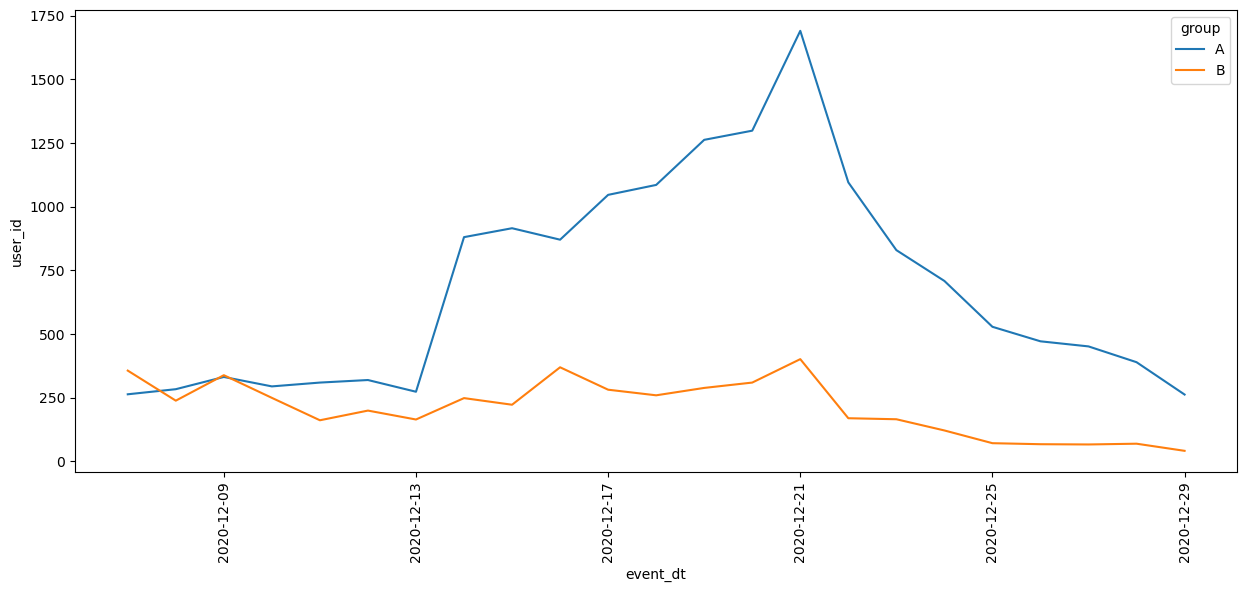

In [54]:
# Строим график динамики набора пользователей
plt.figure(figsize=(15,6))
ax = sns.lineplot(data=new_users_by_group, x='event_dt', y='user_id', hue='group')
#x.set_xticks(new_users_by_group['event_dt'])
plt.xticks(rotation=90)

<font color='DarkMagenta'> Теперь стало понятно откуда появился такой рост в количестве событий у группы А. С 14 декабря заметен резкий скачок количества пользователей в группе А, которое увеличивалось вплоть до 21 декабря. В это самое время в группе В количество новых пользователей в день не сильно колеблется. Отсюда и такая разница в размере групп. Необходимо проверить механизм распределения пользователей по группам.

### Изменение конверсии в воронке в группах на разных этапах.

In [55]:
# Посмотрю как часто встречаются события. Отсортирую их по убыванию
funnel_of_events = (df['event_name']
                    .value_counts()
                    .to_frame()
                    .reset_index()
                    .rename(columns={'index':'event_name',
                                    'event_name':'event_cnt'})
                   )
funnel_of_events

,event_name,event_cnt
0,login,9363
1,product_page,5771
2,purchase,2829
3,product_cart,2739


<font color='DarkMagenta'> По частоте события располагаются следующим образом:<br> 1) login	- вход<br>2) product_page - просмотр карточек товаров <br>3) purchase - покупка<br> 4) product_cart - просмотры корзины   

<font color='DarkMagenta'> Логично утверждать, что воронка событий должна идти в следующем порядке:<br> 1) login - вход<br>2) product_page - просмотр карточек товаров<br>3) product_cart - просмотры корзины<br> 4) purchase - покупка

In [56]:
# Подготовлю данные для воронки
event_by_group = (
    df
    .pivot_table(
        index='event_name',
        columns = 'group',
        values = 'user_id',
        aggfunc='nunique')
    .reset_index()
    .reindex([0,2,1,3])
)
event_by_group

group,event_name,A,B
0,login,2279,876
2,product_page,1476,493
1,product_cart,686,244
3,purchase,734,249


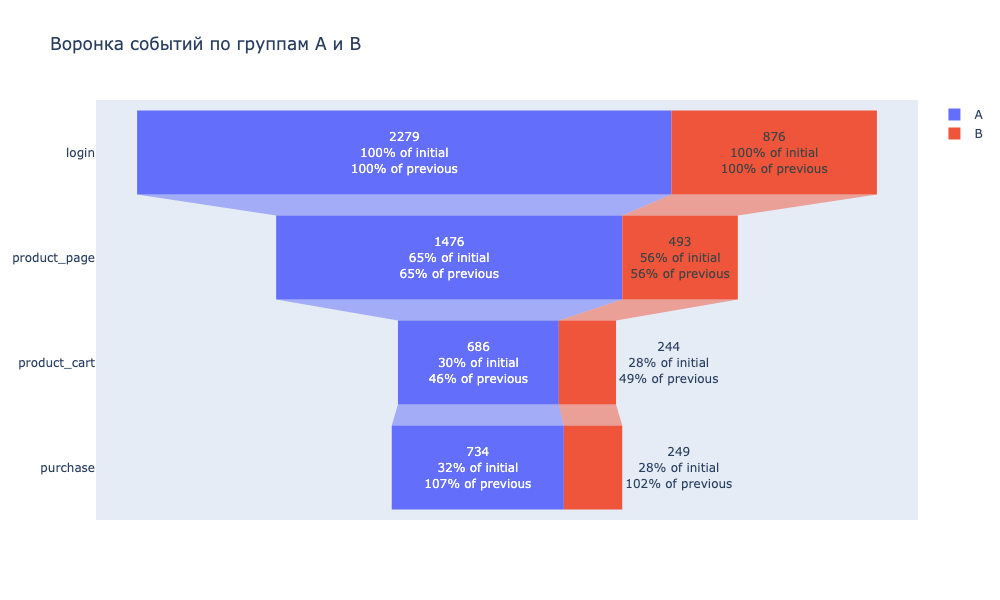

In [57]:
# Построю воронку событий
fig = go.Figure(layout=dict(title=dict(text="Воронка событий по группам А и В")))

fig.add_trace(go.Funnel(
    name = 'A',
    orientation = "h",
    y = event_by_group['event_name'],
    x = event_by_group['A'],
    textinfo = "value+percent previous+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = event_by_group['event_name'],
    x = event_by_group['B'],
    textinfo = "value+percent previous+percent initial"))


fig.show(renderer="png", width=1000, height=600)

<font color='DarkMagenta'> По таблице и по графику воронки видно, что есть те пользователели, которые оплачивают товар, минуя корзину. Ни один из этапов воронки не показал улучшение метрики на 10% относительно контрольной группы. Конверсия  в каждое событие тестируемой группы В хуже, чем результаты контрольной группы А.

### Выводы по исследовательскому анализу

- Пользователь группы А совершает больше событий, чем пользователь группы В.

- Пользователи группы А совершают больше событий. Это логично, т.к. количество пользователей в этой группе в 2,5 раза больше. Самое большое количество событий в обеих группах было в один день 2020-12-21.

- С 14 декабря у группы А наблюдается резкий рост в количестве событий. Ранее мы выяснили, что по понедельникам 7, 14 и 21 числа происходил самый большой приток пользователей.

- С 14 декабря заметен резкий скачок количества пользователей в группе А, которое увеличивалось вплоть до 21 декабря. В это самое время в группе В количество новых пользователей в день не сильно колеблется. Отсюда и такая разница в размере групп. Необходимо проверить механизм распределения пользователей по группам.

- Есть пользователи, которые оплачивают товар, минуя корзину. Ни один из этапов воронки не показал улучшение метрики на 10% относительно контрольной группы. Конверсия в каждое событие тестируемой группы В хуже, чем результаты контрольной группы А.

## Оценка результатов А/В-тестирования

In [58]:
# Выведу количество пользователей в каждой группе
user_by_group = df.groupby('group')['user_id'].nunique()
user_by_group

group
A    2279
B     877
Name: user_id, dtype: int64

**Проведу z-тест между группами А и В по всем событиям.**
- H0 - доли между группами А и В равны
- H1 - доли между группами А и В не равны

Установлю уровень статистической значимости 0,05

In [59]:
def z_test(group_1, group_2, alpha):
    for i in event_by_group.index:
        # пропорция успехов в первой группе:
        p1 = event_by_group[group_1][i]/user_by_group[group_1]

        # пропорция успехов во второй группе:
        p2 = event_by_group[group_2][i]/user_by_group[group_2]
        
        print(event_by_group[group_1][i], event_by_group[group_2][i], user_by_group[group_1], user_by_group[group_2])

        # пропорция успехов в комбинированном датасете:
        p_combined = (event_by_group[group_1][i] + event_by_group[group_2][i]) / (user_by_group[group_1] + user_by_group[group_2])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/user_by_group[group_1] + 1/user_by_group[group_2]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
         # Т.к. всего проведем 4 теста, то посчитаем уровень статистической значимости с поправкой Боферрони
        bonferroni_alpha = alpha/4 
        print('p-значение события {} между группами {} и {} равно {}'.format(event_by_group['event_name'][i], group_1, group_2, p_value))

        if p_value < bonferroni_alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            ) 
        print('='*50)

In [60]:
z_test('A', 'B', 0.05)

2279 876 2279 877
p-значение события login между группами A и B равно 0.10690044633093154
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
1476 493 2279 877
p-значение события product_page между группами A и B равно 8.902264545529448e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
686 244 2279 877
p-значение события product_cart между группами A и B равно 0.20843147684279728
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
734 249 2279 877
p-значение события purchase между группами A и B равно 0.03816633858947882
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<font color='DarkMagenta'>Было проведено 4 тестов. По результатам тестов выяснили, что статистические критерии находят разницу между экспериментальными группами только в событии product_page.

## Общие выводы

**Общие выводы по проведенному исследованию**

- Набор новых пользователей в наш тест был завершен 23 декабря. В задании сказано, что набор должен был быть остановлен 21 декабря. Но в тесте приняли участие пользователи, которые зарегистрировались с 2020-12-07 до 2020-12-21 включительно. Это соответствует техническому заданию.

- Больше всех пользователей пришло 2020-12-14 и 2020-12-21

- В тест попали не только пользователи из Европы, но количество европейских пользователей в тесте соответствует ожидаемому количеству. И их доля от общего количества пользователей составляет 15%, как и должно быть по условию теста.

- Т.к. тест был направлен на пользователей из Европы, то мы удалили пользователей всех других регионов из теста.

- Между группами исследуемого теста перессечений нет, но есть пересечения обеих групп с группой В теста interface_eu_test. Это может сильно отразиться на результатах теста

- Группа А нашего теста - контрольная. Поэтому удалили из теста пользователей, которые одновременно участвуют в гуппе А нашего теста и и группе В конкурирующего.

- Снизилось и количество учатников в тесте, и доля пользователей из Европы уже не 15%, но удаление пересекающихся между тестами пользователей было необходимо.

- В группе А на 8% больше участников. Если удалить из группы В участников, которые пересекаются с группой В конкурирующего теста, то разница станет еще больше и это сильно снизит мощность теста. Поэтому оставили в группе В нашего теста пользователей, которые попали в группу В конкурирующего теста.

- 2/3 пользователей, которые не совершили ни одного действия находятся в группе В.

- Данные по совершенным событиям есть только за период с 2020-12-07 до полудня 2020-12-30. Возможно что-то случилось в новогодние праздники, поэтому данные выгрузились не за весь период. Но с этим мы ничего сделать не можем, будем работать с теми данными, что есть.

- На территории Европы во время проведения теста будет проходить только 1 маркетинговая кампания. Но она в равной степени будет влиять на обе группы, поэтому не буду удалять из основного датафрейма даты, в которые совершались события во время проведения маркетинговых активностей.

- По ТЗ мы должны проверить коверсию только за 14 дней с момента регистрации пользователя. Удалили в таблице все события, которые произошли после 14 дней с момента регистрации пользователя в приложении.

- Пользователи группы А совершают больше событий. 

- С 14 декабря у группы А наблюдается резкий рост в количестве событий. Ранее мы выяснили, что по понедельникам 7, 14 и 21 числа происходил самый большой приток пользователей.

- С 14 декабря заметен резкий скачок количества пользователей в группе А, которое увеличивалось вплоть до 21 декабря. В это самое время в группе В количество новых пользователей в день не сильно колеблется. Отсюда и такая разница в размере групп. Необходимо проверить механизм распределения пользователей по группам.

- Есть пользователи, которые оплачивают товар, минуя корзину. Ни один из этапов воронки не показал улучшение метрики на 10% относительно контрольной группы. Конверсия в каждое событие тестируемой группы В хуже, чем результаты контрольной группы А.

- Тест необходимо продолжить, но с обязательно корректировкой количества пользователей в группе В


**Рекомендации**

- Обязательно необходимо проверить механизм распределения пользователей по группам, выявить причины, по котым может происходить неравномерное распределение
- Выяснить, почему данные для анализа только до 30 декабря. Либо тест был остановлен, либо произошли какие-то проблемы в новогодние праздники.
- Можно рассмотреть перенос периода проведения теста на более спокойный, который не будет включать сезонный ажиотаж и маркетинговые активности.
